In [1]:
%matplotlib inline

In [2]:
from clawpack.geoclaw import dtopotools
import numpy as np
import matplotlib.pyplot as pl

## Comninou & Dundurs model (Okada model for triangular faults)

In this notebook, we will check the results for the newly written Comninou & Dundurs model in `dtopotools`, which computes the elastic half-space deformations due to triangular faults.

This code currently is stored in: 
   
   * the fork `github.com/dsrim/geoclaw` in the branch `triangular_angular`.

First, we load a `SiftFault` to import a rectangular fault

In [3]:
fault = dtopotools.SiftFault({'acszb2':1.})
subfault0 = fault.subfaults[0]
subfault0.calculate_geometry()

Then, we first compute the seafloor deformation using the Okada model

In [4]:
# Find a sufficiently large rectangle containing the fault
lims = fault.containing_rect()
slip = 1.

# setting limits to compute the deformations
x0 = lims[0]-1.
x1 = lims[1]+1.

y0 = lims[2]-1.
y1 = lims[3]+1.

x = np.linspace(x0,x1,100)
y = np.linspace(y0,y1,100)
fault.subfaults[0].slip = slip
dtopo0 = fault.create_dtopography(x,y,times=[0.])

/Users/dsrim/local/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:1298: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/Users/dsrim/local/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:1303: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


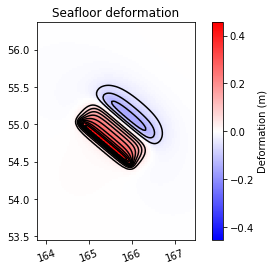

In [5]:
dtopo0.plot_dZ_colors(0.);

The *strike*, *dip*, *rake*, *depth*, *width*, and *length* of this fault is given as:

In [6]:
print('strike = ' + '{:6.2f}'.format(subfault0.strike))
print('dip = ' + '{:6.2f}'.format(subfault0.dip))
print('rake = ' + '{:6.2f}'.format(subfault0.rake))
print('depth = ' + '{:6.2f}'.format(subfault0.depth))
print('width = ' + '{:6.2f}'.format(subfault0.width))
print('length = ' + '{:6.2f}'.format(subfault0.length))

strike = 310.17
dip =  17.00
rake =  90.00
depth = 5000.00
width = 50000.00
length = 100000.00


The long-lat coordinates of the four vertices of the rectangle is stored in the variable `subfault0.corners`:

In [7]:
print('four corners = ')
print(np.array(subfault0.corners))

four corners = 
[[   164.77256579     55.03484865   5000.        ]
 [   165.25732146     55.36361659  19618.58523614]
 [   166.45827854     54.78318341  19618.58523614]
 [   165.97352287     54.45441547   5000.        ]]


### Setting up a triangular fault

A triangular fault is designated by supplying the long-lat-depth coordinates of the three corners to the subfault `subfault.set_corners` routine.

In [8]:
rect_corners = subfault0.corners

subfault1 = dtopotools.SubFault()
subfault2 = dtopotools.SubFault()

subfault1.set_corners([rect_corners[0],rect_corners[1],rect_corners[2]])
subfault2.set_corners([rect_corners[0],rect_corners[2],rect_corners[3]])

In [9]:
print('corners for subfault 1 =')
print(np.array(subfault1.corners))
print(' ')
print('corners for subfault 2 =')
print(np.array(subfault2.corners))

corners for subfault 1 =
[[   164.77256579     55.03484865   5000.        ]
 [   165.25732146     55.36361659  19618.58523614]
 [   166.45827854     54.78318341  19618.58523614]]
 
corners for subfault 2 =
[[   164.77256579     55.03484865   5000.        ]
 [   166.45827854     54.78318341  19618.58523614]
 [   165.97352287     54.45441547   5000.        ]]


In [10]:
print('subfault0 strike: ' + '{:6.2f}'.format( subfault1.strike))
print('subfault1 strike: ' + '{:6.2f}'.format( subfault2.strike))
print('strike difference: ' + '{:6.2f}'.format( subfault2.strike - subfault1.strike))
print('---')
print('subfault0 dip: ' + '{:6.2f}'.format( subfault1.dip))
print('subfault1 dip: ' + '{:6.2f}'.format( subfault2.dip))
print('---')
print('subfault0 depth: ' + '{:6.2f}'.format( subfault1.depth))
print('subfault1 depth: ' + '{:6.2f}'.format( subfault2.depth))
print('---')
print('subfault0 rake: ' + '{:6.2f}'.format( subfault1.rake))
print('subfault1 rake: ' + '{:6.2f}'.format( subfault2.rake))
print('---')
print('subfault0 unit slip vector: ' + str(subfault1._get_unit_slip_vector()))
print('subfault1 unit slip vector: ' + str(subfault2._get_unit_slip_vector()))

subfault0 strike: -49.84
subfault1 strike: -50.05
strike difference:  -0.21
---
subfault0 dip:  17.00
subfault1 dip:  16.95
---
subfault0 depth: 14745.72
subfault1 depth: 9872.86
---
subfault0 rake:  90.00
subfault1 rake:  90.00
---
subfault0 unit slip vector: [-0.6167631  -0.73085084  0.29233599]
subfault1 unit slip vector: [-0.61421172 -0.73332785  0.2915034 ]


deformation from two triangular faults to the left, Okada to the right


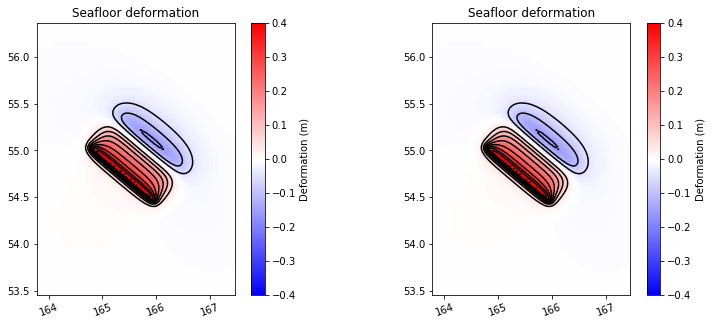

In [11]:
rake = 90.

subfault1.rake = rake
subfault2.rake = rake

subfault1.slip = slip
subfault2.slip = slip

# put two subfaults into a fault
fault1 = dtopotools.Fault()
fault1.subfaults = []
fault1.subfaults.append(subfault1)
fault1.subfaults.append(subfault2)

# compute deformation
dtopo1 = fault1.create_dtopography(x,y,times=[0.]);

print('deformation from two triangular faults to the left, Okada to the right')
fig,ax = pl.subplots(nrows=1, ncols=2, figsize=(13,5))
dtopo1.plot_dZ_colors(0.,axes = ax[0], cmax_dZ=0.4, dZ_interval=0.05);
dtopo0.plot_dZ_colors(0.,axes = ax[1], cmax_dZ=0.4, dZ_interval=0.05);

('min /max of ddZ: ', (-0.004233183072332114, 0.010866328262505887))


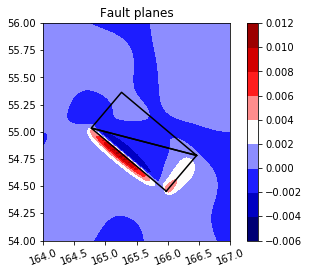

In [12]:
ddZ = dtopo1.dZ[-1,:,:] - dtopo0.dZ[-1,:,:]
print('min /max of ddZ: ', (ddZ.min(), ddZ.max()))

cm=pl.get_cmap('seismic')
fault1.plot_subfaults();
pl.contourf(x,y,ddZ,cmap=cm)
pl.xlim(164,167)
pl.ylim(54.,56)
pl.colorbar();

Plot of the two triangular subfaults


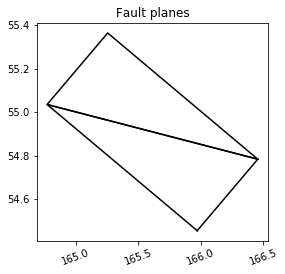

In [13]:
print('Plot of the two triangular subfaults')
fault1.plot_subfaults();

In [14]:
print('mean error = ' + '{:6.4f}'.format(np.mean(np.abs(dtopo1.dZ - dtopo0.dZ))))

mean error = 0.0002


deformations from two triangles separately


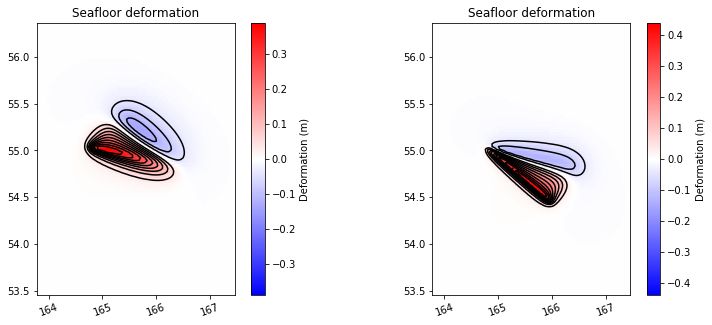

In [15]:
f,ax = pl.subplots(nrows=1,ncols=2,figsize=(13,5));

dtopoT1 = subfault1.okada(x,y)
dtopoT2 = subfault2.okada(x,y)

print('deformations from two triangles separately')
dtopoT1.plot_dZ_colors(0.,axes=ax[0]);
dtopoT2.plot_dZ_colors(0.,axes=ax[1]);

## TODO

* bulk set a lot of triangles through an attribute function for `Fault` object
* read / write, especially for slab format

## Try subdividing fault to get better agreement?

In [16]:
fault2 = dtopotools.SubdividedPlaneFault(subfault0, nstrike=16, ndip=8)

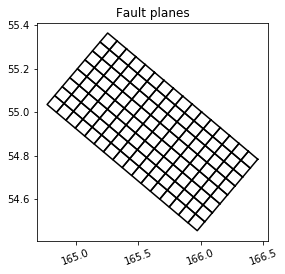

In [17]:
fault2.plot_subfaults()

In [18]:
# compute deformation
dtopo2 = fault2.create_dtopography(x,y,times=[0.]);

In [19]:
fault3 = dtopotools.Fault()
fault3.subfaults = []
for s in fault2.subfaults:
    rect_corners = s.corners
    subfault1 = dtopotools.SubFault()
    subfault2 = dtopotools.SubFault()
    subfault1.slip = slip
    subfault2.slip = slip
    subfault1.set_corners([rect_corners[0],rect_corners[1],rect_corners[2]])
    subfault2.set_corners([rect_corners[0],rect_corners[2],rect_corners[3]])
    #print(subfault1.latitude, subfault1.longitude)
    fault3.subfaults.append(subfault1)
    fault3.subfaults.append(subfault2)

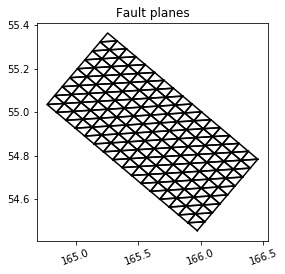

In [20]:
fault3.plot_subfaults()

deformation from triangulation to the left, Okada to the right


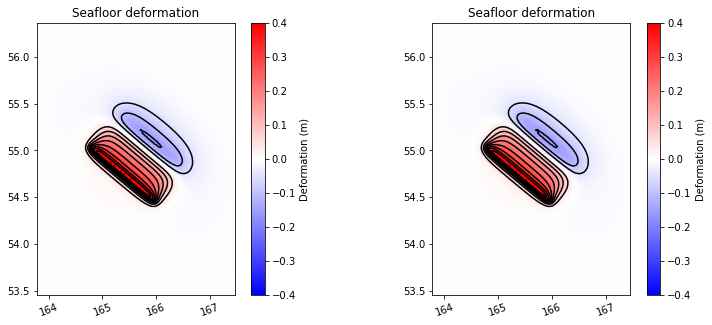

In [21]:
# compute deformation
dtopo3 = fault3.create_dtopography(x,y,times=[0.]);

print('deformation from triangulation to the left, Okada to the right')
fig,ax = pl.subplots(nrows=1, ncols=2, figsize=(13,5))
dtopo3.plot_dZ_colors(0.,axes = ax[0], cmax_dZ=0.4, dZ_interval=0.05);
dtopo2.plot_dZ_colors(0.,axes = ax[1], cmax_dZ=0.4, dZ_interval=0.05);

('min /max of ddZ: ', (-9.7164756922953413e-05, 0.00083534509497085185))


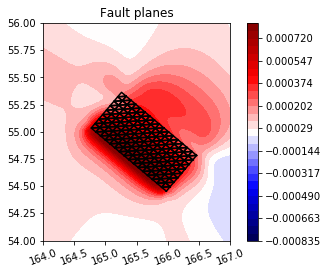

In [22]:
ddZ = dtopo3.dZ[-1,:,:] - dtopo2.dZ[-1,:,:]
print('min /max of ddZ: ', (ddZ.min(), ddZ.max()))

vmax = np.max([np.abs(ddZ.min()),np.max(ddZ.max())])
cm=pl.get_cmap('seismic')
fault3.plot_subfaults();
pl.contourf(x,y,ddZ,np.linspace(-vmax,vmax,30),cmap=cm)
pl.xlim(164,167)
pl.ylim(54.,56)
pl.colorbar();

In [23]:
print('ell 1 error: ' +  str(np.mean(np.abs(ddZ))))

ell 1 error: 0.000105528960526
